<a href="https://colab.research.google.com/github/nitesh-dubey/Abstractive-Text-Summarization/blob/master/Abstractive_Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstractive Text Summarization
 
***Nitesh Dubey - IIIT Guwahati***

In This notebook we use Amazon Food Reviews Dataset to train *Abstractive Text Summarization* model, to output the summary of give reviews.

In [1]:
# Dataset used = Amazon Fine Food Reviews dataset
# link = 'https://www.kaggle.com/snap/amazon-fine-food-reviews'

from google.colab import drive
drive.mount('/content/gdrive')
dir_path = '/content/gdrive/My Drive/Colab Notebooks/Abstractive Text Summarization/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.0.0-beta1
import tensorflow as tf
print(tf.__version__)

1.15.0


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Bidirectional, Concatenate
from tensorflow.keras.layers import TimeDistributed, BatchNormalization, Dropout 
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.CRITICAL)

In [5]:
df = pd.read_csv(dir_path + 'Reviews.csv', nrows = 150000)
df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [0]:
df = df[['Text', 'Summary']]
df.drop_duplicates(subset = ['Text'], inplace = True)
df.dropna(axis = 0, inplace = True)

# Data Preprocessing

In [0]:
# Taken from Stack Overflow

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


In [0]:
def clean_text(text):
  cleantext = text.lower()
  cleantext = BeautifulSoup(cleantext, 'lxml').text
  cleantext = re.sub(r'\([^)]*\)', '', cleantext)
  cleantext = " ".join([contraction_mapping[x] if x in contraction_mapping else x for x in cleantext.split()])
  cleantext = re.sub(r"'s\b", '', cleantext)
  cleantext = re.sub('"','',cleantext)
  cleantext = re.sub(r"[^a-zA-Z]", " ", cleantext)
  cleantext = " ".join([x for x in cleantext.split() if x not in set(stopwords.words('english'))])
  cleantext = " ".join([x for x in cleantext.split() if len(x) >= 3])
  return cleantext


In [0]:
def clean_summary(suma):
  suma = suma.lower()
  suma = BeautifulSoup(suma, 'lxml').text
  suma = re.sub(r'\([^)]*\)', '', suma)
  suma = " ".join([contraction_mapping[x] if x in contraction_mapping else x for x in suma.split()])
  suma = re.sub(r"\'s\b", "", suma)
  suma = re.sub(r"[^a-zA-Z]", " ", suma)
  suma = " ".join(suma.split())
  if suma == "":
    suma = np.nan
  else:
    suma = "<start> " + suma + " <end>"
  return suma

In [10]:
# Cleaning And Saving the Cleaned data drive

# df['Text'] = df['Text'].apply(lambda x : clean_text(x))
# df['Summary'] = df['Summary'].apply(lambda x : clean_summary(x))
# df.dropna(axis = 0, inplace = True)
# df.to_csv(dir_path + 'cleaned_reviews.csv')

#Loading cleaned dataset
df = pd.read_csv(dir_path + 'cleaned_reviews.csv')

df.head(10)

,Unnamed: 0,Text,Summary
0,0,bought several vitality canned dog food produc...,<start> good quality dog food <end>
1,1,product arrived labeled jumbo salted peanuts p...,<start> not as advertised <end>
2,2,confection around centuries light pillowy citr...,<start> delight says it all <end>
3,3,looking secret ingredient robitussin believe f...,<start> cough medicine <end>
4,4,great taffy great price wide assortment yummy ...,<start> great taffy <end>
5,5,got wild hair taffy ordered five pound bag taf...,<start> nice taffy <end>
6,6,saltwater taffy great flavors soft chewy candy...,<start> great just as good as the expensive br...
7,7,taffy good soft chewy flavors amazing would de...,<start> wonderful tasty taffy <end>
8,8,right mostly sprouting cats eat grass love rot...,<start> yay barley <end>
9,9,healthy dog food good digestion also good smal...,<start> healthy dog food <end>


# Analyzing the Data

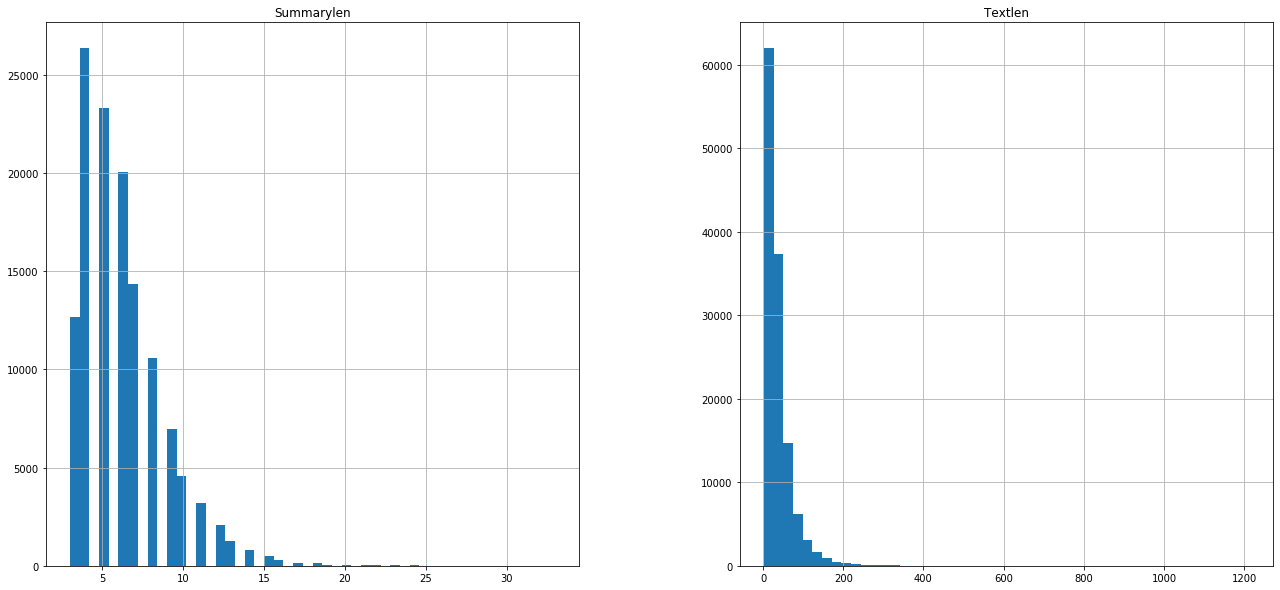

In [11]:
plt.rcParams['figure.figsize'] = (22,10)
def analyze(data):
  textlen, sumalen = [],[]
  for i in range(data.shape[0]):
    textlen.append(len(data.iloc[i]['Text'].split()))
    sumalen.append(len(data.iloc[i]['Summary'].split()))
  egsize = pd.DataFrame({'Textlen' : textlen, 'Summarylen' : sumalen})
  egsize.hist(bins = 50)

analyze(df)

We see that most of Text Sentences are less than 80 words and Summaries are less than 10 words.

In [0]:
max_text, max_suma = 80,12

In [0]:
# Splitting dataset into train and dev
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val =  train_test_split(df['Text'], df['Summary'], test_size = 0.1, shuffle = True, random_state = 42)

# Tokenization

In [0]:
#During Training

x_tokenizer, y_tokenizer = Tokenizer(), Tokenizer()

x_tokenizer.fit_on_texts(x_tr.tolist())
x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_val = x_tokenizer.texts_to_sequences(x_val)
x_tr = pad_sequences(x_tr, maxlen = max_text, padding = 'post')
x_val = pad_sequences(x_val, maxlen = max_text, padding = 'post')
x_vocabsize = len(x_tokenizer.word_index) + 1                       # +1 for padding

y_tokenizer.fit_on_texts(y_tr.tolist())
y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_val = y_tokenizer.texts_to_sequences(y_val)
y_tr = pad_sequences(y_tr, maxlen = max_suma, padding = 'post')
y_val = pad_sequences(y_val, maxlen = max_suma, padding = 'post')
y_vocabsize = len(y_tokenizer.word_index) + 1                       # +1 for padding

# Model Building

# Training

In [0]:
dim = 250
emb_dim = 450

#Encoder
encoder_inputs = Input(shape = (max_text,))
enc_emb_layer = Embedding(x_vocabsize, emb_dim, trainable = True, name = 'x_emb')
enc_emb_out = enc_emb_layer(encoder_inputs)

#Bi-LSTM 1
enc_bilstm1 = Bidirectional(LSTM(dim, return_sequences = True, return_state = True, dropout = 0.35, recurrent_dropout=0.3, name = 'enc_lstm1'))
enc_lstm1_out,forw_h1,forw_c1, back_h1, back_c1 = enc_bilstm1(enc_emb_out)
h1 = Concatenate()([forw_h1, back_h1])
c1 = Concatenate()([forw_c1, back_c1])


#Decoder

decoder_inputs = Input(shape = (None,))
dec_emb_layer = Embedding(y_vocabsize, emb_dim, trainable = True, name = 'y_emb')
dec_emb_out = dec_emb_layer(decoder_inputs)

#LSTM
dec_lstm = LSTM(2*dim, return_sequences = True, return_state = True, dropout = 0.3, recurrent_dropout=0.3, name = 'dec_lstm')
dec_out,h,c = dec_lstm(dec_emb_out, initial_state = [h1,c1])

#Attention
atten_layer = tf.keras.layers.Attention()
atten_out = atten_layer([dec_out,enc_lstm1_out])
concat_layer = Concatenate()
dec_input = concat_layer([dec_out,atten_out])

decoder_dense_layer = TimeDistributed(Dense(y_vocabsize, activation = 'softmax'))
dec_out = decoder_dense_layer(dec_input)
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs = [dec_out])

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
x_emb (Embedding)               (None, 80, 450)      28337400    input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, 80, 500), (N 1402000     x_emb[0][0]                      
____________________________________________________________________________________________

In [0]:
#Sparse categorical_crossentropy changes integers to onehot on the fly
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')

In [0]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2, verbose = 1)

In [0]:
history = model.fit(x=[x_tr, y_tr[:,:-1]], y=y_tr[:,1:] , batch_size=64, epochs = 50, callbacks = [es], validation_data = ([x_val,y_val[:,:-1]], y_val[:,1:]))

Train on 114753 samples, validate on 12751 samples
Epoch 1/50
114753/114753 [==============================] - 623s 5ms/sample - loss: 2.3463 - val_loss: 1.9561
Epoch 2/50
114753/114753 [==============================] - 620s 5ms/sample - loss: 1.8610 - val_loss: 1.7804
Epoch 3/50
114753/114753 [==============================] - 618s 5ms/sample - loss: 1.6213 - val_loss: 1.7311
Epoch 4/50
114753/114753 [==============================] - 618s 5ms/sample - loss: 1.4277 - val_loss: 1.7362
Epoch 5/50
114753/114753 [==============================] - 615s 5ms/sample - loss: 1.2614 - val_loss: 1.7663
Epoch 00005: early stopping


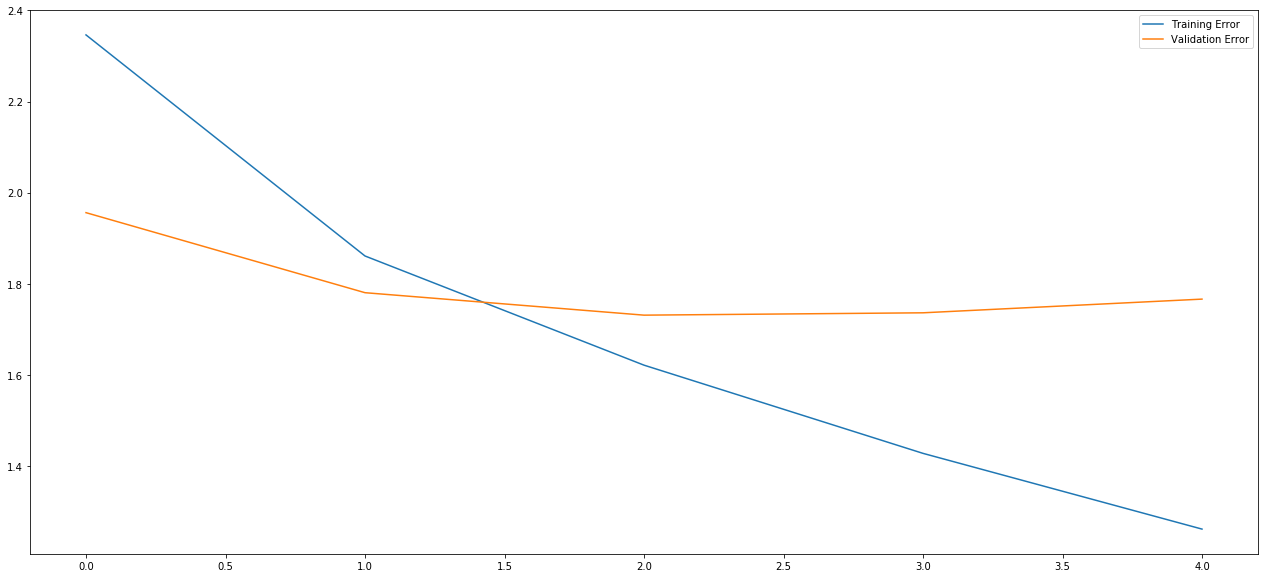

In [0]:
plt.plot(history.history['loss'], label = 'Training Error')
plt.plot(history.history['val_loss'], label = 'Validation Error')
plt.legend()
plt.show()

# Inference
Now that the Network is Trained, we have to make inference model for generating summary of the given input to encoder

In [0]:
encoder_model = Model(inputs = [encoder_inputs], outputs = [enc_lstm1_out, h1, c1])

#Decoder Model
h_input = Input(shape = (2*dim,))
c_input = Input(shape = (2*dim,))
enc_outputs = Input(shape = (max_text, 2*dim))

dec_emb_outputs = dec_emb_layer(decoder_inputs)
dec_out,h,c = dec_lstm(dec_emb_outputs, initial_state = [h_input,c_input])
atten_out = atten_layer([dec_out, enc_outputs])
dense_input = concat_layer([dec_out, atten_out])
dec_out = decoder_dense_layer(dense_input)

decoder_model = Model(inputs = [decoder_inputs, h_input, c_input, enc_outputs], outputs = [dec_out,h,c])


In [0]:
#During Training

# Saving Models
# Saving train.h5
# model.save(dir_path + 'train.h5')

# Saving Encoder-Decoder Models
# encoder_model.save(dir_path + 'encoder.h5') 
# decoder_model.save(dir_path + 'decoder.h5')

# Saving Tokenizers
import pickle
# with open(dir_path + 'x_tokenizer.pickle', 'wb') as handle:
#   pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(dir_path + 'y_tokenizer.pickle', 'wb') as handle:
#   pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#During Testing

#Loading Tokenizers
with open(dir_path + 'x_tokenizer.pickle', 'rb') as handle:
  x_tokenizer = pickle.load(handle)
with open(dir_path + 'y_tokenizer.pickle', 'rb') as handle:
  y_tokenizer = pickle.load(handle)

# Generating sequences using tokenizers. (Run only during testing time, else comment it out)
x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_val = x_tokenizer.texts_to_sequences(x_val)
x_tr = pad_sequences(x_tr, maxlen = max_text, padding = 'post')
x_val = pad_sequences(x_val, maxlen = max_text, padding = 'post')
x_vocabsize = len(x_tokenizer.word_index) + 1                    

y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_val = y_tokenizer.texts_to_sequences(y_val)
y_tr = pad_sequences(y_tr, maxlen = max_suma, padding = 'post')
y_val = pad_sequences(y_val, maxlen = max_suma, padding = 'post')
y_vocabsize = len(y_tokenizer.word_index) + 1             

#Loading h5 models
from tensorflow.keras.models import load_model
model = load_model(dir_path + 'train.h5')
encoder_model = load_model(dir_path + 'encoder.h5')
decoder_model = load_model(dir_path + 'decoder.h5')

In [0]:
#Dictionaries
y_word_to_ind = y_tokenizer.word_index
y_ind_to_word = y_tokenizer.index_word
x_ind_to_word = x_tokenizer.index_word
x_word_to_ind = x_tokenizer.word_index

def summarize(sequence):
  enc_outputs, h, c = encoder_model.predict(sequence)

  out_seq, pred, suma_size = [],'start',0

  while suma_size <= max_suma and pred != 'end':
    dec_out, h, c = decoder_model.predict([np.array([y_word_to_ind[pred]]).reshape(1,1), h, c, enc_outputs])
    sampled_ind = np.argmax(dec_out[0,-1,:])
    pred = y_ind_to_word[sampled_ind]
    if pred != 'end':
      out_seq.append(pred)
    suma_size += 1
  summary = " ".join(out_seq)
  return summary


In [0]:
def seq_to_text(seq):
  text = ''
  for x in seq:
    if x != 0:
      text += " " + x_ind_to_word[x]
  return text

def seq_to_summary(seq):
  summary = ''
  for x in seq:
    if x!=0 and y_ind_to_word[x] != 'start' and y_ind_to_word[x] != 'end':
      summary += " " + y_ind_to_word[x]
  return summary

In [53]:
for i in range(1500,1520):
  print('Text : ', seq_to_text(x_val[i]))
  print('Original Summary : ', seq_to_summary(y_val[i]))
  print('Predicted Summary : ', summarize(x_val[i].reshape(1,max_text)))
  print('\n')

Text :   aweful super hard tasteless bought thinking would fun kids none wanted
Original Summary :   aweful
Predicted Summary :  not what i expected


Text :   dear friend mine feeling sick want eat anything ate liked well maybe loved would know since express directly appreciative shared also made another time friend mine borderline could actually eat loved thrilled found something else gluten free complimented always finding great tasting gluten free food anyone walk life dietary problems eat enjoy best part mix match seasoning add items wish cook highly recommend honestly would hands buy next chance get whole package roughly makes adult servings depending upon big portions
Original Summary :   better than yo mama traditional pasta
Predicted Summary :  i love this stuff


Text :   wonderful gift wife pregnant first child wanted get something make feel special enjoyed treats especially chocolates would definitely recommend gift friend
Original Summary :   great gift for my wife
Predict

# Testing

In [0]:
def get_summary(text):
  cleaned = clean_text(text)
  seq = x_tokenizer.texts_to_sequences([cleaned])
  seq = pad_sequences(seq, maxlen = max_text, padding = 'post')
  summary = summarize(np.array(seq).reshape(1,max_text))
  return summary

In [38]:
print(get_summary('The place is very conveniently located (on the highway ) with ample parking space. The food at both the meals was tasty and definitely worth the price'))

great snack


In [40]:
print(get_summary("I and my friend had dinner here one of the nights we were in Kalpetta. The ambiance was good and the food recommendations were great. We had a traditional Arabian rice and chicken preparation, Kuzhi Manthi. It was our first experience having this dish, and although a bit dry, it tasted great. Would recommend this place that's easily noticed from a vehicle and has ample parking"))

great for a quick meal


In [41]:
print(get_summary("Awesome place and good hospitality. Staffs are very cooperative. Very easy to enter from Highway. Foods are yummy. I love to visit here again with my family. Had a nice time with family."))

yummy


In [43]:
print(get_summary("Very expensive compared to the pricing and portions served. So avoid this dish. Chicken biriyani was OK but portion served is too less for ₹200. I hope the management comes to senses."))

too expensive


In [46]:
print(get_summary("Ordered from here before also. Was very happy earlier. Recently they have increased the prices by about 50%, reduced quantity, and quality has also gone down somewhat. No longer value for money great food. Disappointed."))

good quality but dusty


In [47]:
print(get_summary("Really bad and a total waste of money....ordered a quinoa salad and had to scatter through the lettuce which was in abundance to find quinoa.....Bland peas and raw beans very disappointing and bad experience ......never ordering again"))

not what i expected


In [48]:
print(get_summary("The food quality is very very bad had order some soup it was so terrible could eat more than a spoonful. They need to change the chef at the earliest. The service and ambiance is okay."))

terrible


In [51]:
print(get_summary("Poor quality service.We had to wait a good 30 minutes before someone noticed us and the restaurant was practically empty at that Time . The food was mediocre too.Never recommending this to anybody."))

poor quality


In [52]:
print(get_summary("I had lunch with some of my colleagues at Echo on Day 1. I had the wedge salad - it was delicious. On Night 2, I enjoyed a drink at the bar. I had a Margarita. The service was excellent."))

a great treat


In this Notebook, we Used Amazon Food Reviews dataset to make Abstractive Text Summarization, which takes Customer Reviews as Input and outputs meaningful summary of the depicted context in Review..

Note :=>  Though we are getting Meaningful sentences, the model has some flaws and few improvements and further tuning can be done if one has good GPU to improve the accuracy of the model.